In [1]:
import fitsio as ft
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('/users/PHS0336/medirz90/github/LSSutils')
from lssutils import utils as ut

import healpy as hp
from lssutils.stats.nnbar import get_meandensity, MeanDensity

In [2]:
randir = '/fs/ess/PHS0336/data/rongpu/'
ran = ft.read(randir+'randoms-1-0.fits',columns=['RA','DEC'])
ran_lrgmask = ft.read(randir+'randoms-1-0lrgimask.fits')

In [3]:
assert ran.size == ran_lrgmask.size

In [4]:
lrg_mask_frac = np.zeros(256*256*12)
ranmap = np.zeros(256*256*12)
ranmap_lmask = np.zeros(256*256*12)

ranpix = ut.radec2hpix(256, ran['RA'], ran['DEC'])
for pix,mvalue in zip(ranpix,ran_lrgmask['lrg_mask']):
    ranmap[pix] += 1
    if mvalue > 1:
        ranmap_lmask[pix] += 1
sel = ranmap > 0
lrg_mask_frac[sel] = ranmap_lmask[sel]/ranmap[sel]

In [5]:
np.unique(ran_lrgmask['lrg_mask'])

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 22, 24, 25, 26, 27, 28, 29, 30, 31], dtype=uint8)

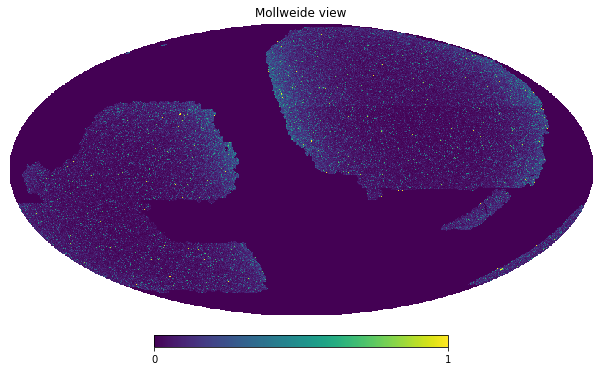

In [6]:
hp.mollview(lrg_mask_frac, rot=-95)

In [8]:
wg = hp.read_map('/fs/ess/PHS0336/data/rongpu/imaging_sys/regression/0.57.0/dnnp_lrg_desic_known1.hp256.fits', verbose=False)

In [9]:
results = {}

for r in ['bmzls', 'ndecalsc', 'sdecalsc']:
    
    dt = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/0.57.0/nlrg_features_{r}_256.fits')
    
    ng = ut.make_hp(256, dt['hpix'], dt['label'])
    msk = ut.make_hp(256, dt['hpix'], 1) > 0.5
    fr = ut.make_hp(256, dt['hpix'], dt['fracgood'])
    
    r_i = MeanDensity(ng, fr, msk, lrg_mask_frac)
    r_i.run()
    

    r_f = MeanDensity(ng, fr, msk, lrg_mask_frac, selection=wg)
    r_f.run()
    
    results[r] = (r_i.output, r_f.output)
    print(r)

bmzls
ndecalsc
sdecalsc


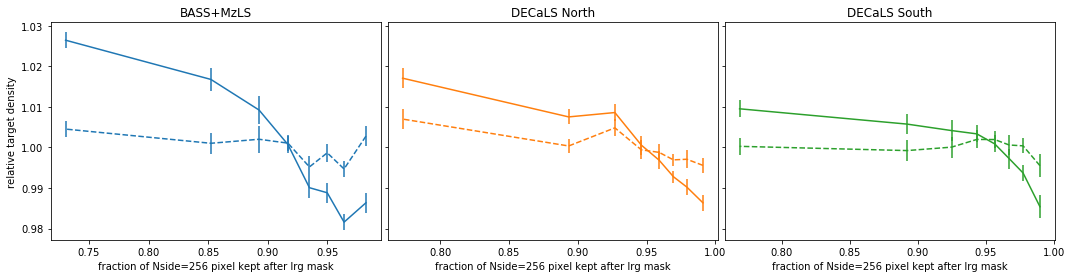

In [17]:
fg, ax = plt.subplots(ncols=3, figsize=(18, 4), sharey=True)
fg.subplots_adjust(wspace=0.02)

rr = ['BASS+MzLS', 'DECaLS North', 'DECaLS South']
for i, r in enumerate(results):
    ax[i].errorbar(1-results[r][0]['bin_avg'], results[r][0]['nnbar'], yerr=results[r][0]['nnbar_err'], color='C%d'%i)
    ax[i].errorbar(1-results[r][1]['bin_avg'], results[r][1]['nnbar'], yerr=results[r][1]['nnbar_err'], color='C%d'%i, ls='--')    
    
    ax[i].set(xlabel='fraction of Nside=256 pixel kept after lrg mask', title=rr[i])
    
ax[0].set_ylabel('relative target density')
fg.savefig('nn_fpix.png', dpi=300, bbox_inches='tight')